## Exercise 1

In this exercise you need to plot ocean depth against ocean age. You have the topography / bathymetry data and the age data. You should do this for the "deep oceans" to avoid including the continental shelves and, for that matter, the continents. The age dataset is only valid where there are magnetic stripes. Other places in the grid are flagged as _"Not a Number"_ or _NaN_ and will not plot. You might have to strip out these points for plotting / curve fitting though.

### Instructions 

You can submit this notebook by email but you MUST rename it so we know who it is from. If you used a crazy pseudonym, please let us know when you submit your assigments. 

I expect to be able to run this notebook before I read your answer!

In [2]:
%pylab inline

from osgeo import gdal

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

from scipy.io import netcdf

Populating the interactive namespace from numpy and matplotlib


## Hint

You will need to have the two datasets at the same resolution and valid data shape. The data are stored in an image so re-interpolation can be done with the image resizing fanciness available in ... (guess where !)

In [3]:
from scipy.misc import imresize

etopoH = gdal.Open("../Data/Resources/ETOPO1_Ice_c_geotiff.tif") 
etopoH_img = etopoH.ReadAsArray()[::4,::4]
del(etopoH)

ages = np.load("../Data/Resources/global_age_data.3.6.z.npz")["ageData"]


etopoH_1 = imresize(etopoH_img, ages.shape, interp='bilinear', mode="F")
etopoH_1[ np.isnan(ages) ] = np.nan

print (etopoH_img.shape)
print (etopoH_1.shape)
print (ages.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  # Remove the CWD from sys.path while we load stuff.


(2700, 5400)
(1801, 3601)
(1801, 3601)


## Task

Make a map of `etopoH_1` and `ages` (check they are the same shape and same NaN mask)

It may also help to plot plate motion arrows on the map to highlight divergent v. convergent zones. In order to do this "intuitively" you probably should choose the NNR (no net rotation) velocity field which tends to show major ridges as spreading in opposite directions. 

You will need to think about:

  * which features are useful to include (a coastline, shaded relief etc ?) 
  * plate motion arrows (see `GlobalPlateMotions` notebook) ? 

In [4]:
coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                           edgecolor=(0.0,0.0,0.0),
                           facecolor="none")

rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',
                                        edgecolor='Blue', facecolor="none")

lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                        edgecolor="blue", facecolor="blue")

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                           edgecolor="green",
                           facecolor="blue")

graticules_5 = cfeature.NaturalEarthFeature('physical', 'graticules_5', '10m',
                           edgecolor="black", facecolor=None)

In [5]:
rootgrp = netcdf.netcdf_file(filename="../Data/Reference/velocity_NNR.nc", version=2)

ve = rootgrp.variables["ve"]
vn = rootgrp.variables["vn"]

lonv = rootgrp.variables["lon"]
latv = rootgrp.variables["lat"]

lons = lonv[::5]
lats = latv[::5]
llX, llY = np.meshgrid(lons,lats)

#llX = llX.reshape(-1)
#llY = llY.reshape(-1)

Veast = (np.array(ve[::5,::5]).T)
Vnorth = (np.array(vn[::5,::5]).T)

Vorientation = np.arctan2(Vnorth,Veast)

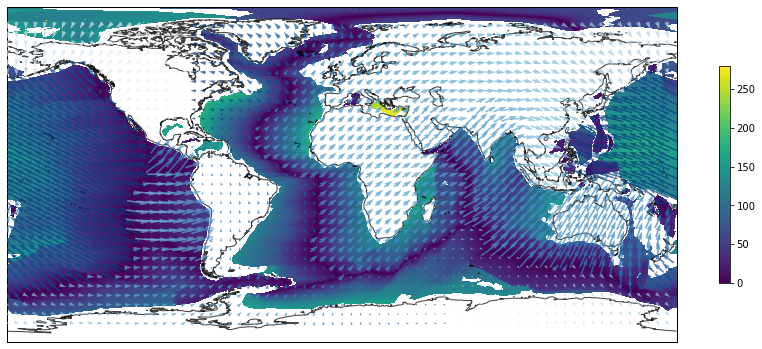

In [6]:
base_projection     = ccrs.PlateCarree() 
global_extent     = [-180.0, 180.0, -90.0, 90.0]
#projection = ccrs.Mollweide(central_longitude=120)

fig = plt.figure(figsize=(15, 8), facecolor="none")
ax = plt.axes(projection=base_projection)
mappable2=ax.imshow(ages[::1,::1], transform=ccrs.PlateCarree(), origin="upper", 
          alpha=1.0, extent=global_extent,  zorder=0)
# ax.imshow(globalrelief_img[::1,::1], transform=ccrs.PlateCarree(), origin="upper", 
#            alpha=1.0, extent=global_extent,  zorder=0)
mappable1=ax.quiver(llX, llY, Veast, Vnorth, Vorientation, scale=2000, transform=ccrs.PlateCarree(),
        cmap=cm.Blues, alpha=0.7, zorder=13, pivot="mid")
ax.add_feature(coastline, linewidth=1.0,  edgecolor="#000000", zorder=2, alpha=0.75)
plt.colorbar(mappable=mappable2, shrink=0.5)

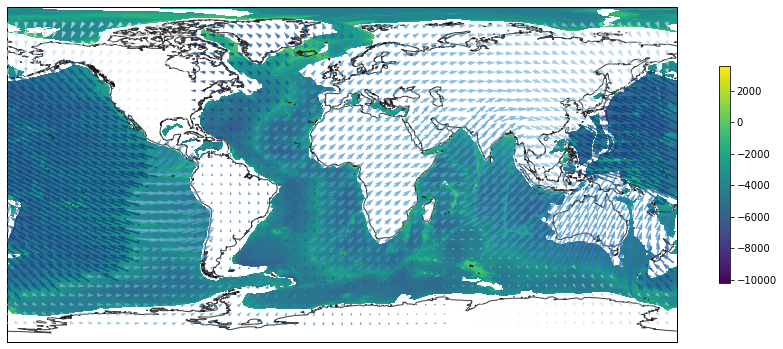

In [7]:
base_projection     = ccrs.PlateCarree() 
global_extent     = [-180.0, 180.0, -90.0, 90.0]

fig = plt.figure(figsize=(15, 8), facecolor="none")
ax = plt.axes(projection=base_projection)
mappable2=ax.imshow(etopoH_1[::1,::1], transform=ccrs.PlateCarree(), origin="upper", 
          alpha=1.0, extent=global_extent,  zorder=0)
mappable1=ax.quiver(llX, llY, Veast, Vnorth, Vorientation, scale=2000, transform=ccrs.PlateCarree(),
        cmap=cm.Blues, alpha=0.7, zorder=13, pivot="mid")
plt.colorbar(mappable=mappable2, shrink=0.5)
ax.add_feature(coastline, linewidth=1.0,  edgecolor="#000000", zorder=2, alpha=0.75)

### Task

Make a scatter plot of the depth against age. You might need to downsample the number of points as there are a lot of them:

```python 
ages_decimated = ages[::10]
topo_decimated = etopoH[::10]
``` 

Do you see any systematic trend ?

**Hint:** don't worry if you do not 

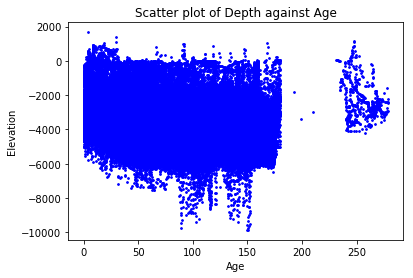

In [8]:
ages_decimated=ages[::10]
topo_decimated=etopoH_1[::10]
plt.scatter(ages_decimated, topo_decimated, c='blue', s=3, alpha=1)
plt.title('Scatter plot of Depth against Age')
plt.xlabel('Age')
plt.ylabel('Elevation')
plt.show()

#From viewing the plot below, there appears to be no systematic trend. Smoothing and downsampling is required. 

# Smoothing

Now try interpolating the bathymetry to a smoothed / downsampled version of the ages.

```python
ages_reduced = ages[::8,::8] # This is arbitrary, you should try some different ones

# OR

ages_reduced2 = imresize(ages, (226,451), interp='bilinear', mode="F")

# OR

ages_reduced2 = imresize(ages, (226,451), interp='bicubic', mode="F")

# OR

ages_reduced2 = imresize(ages, (226,451), interp='lanczos', mode="F")
```

Comment on which of these is the more effective.


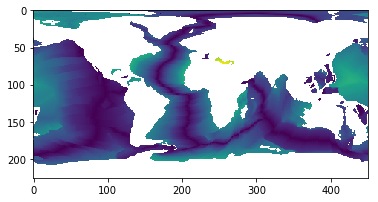

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """


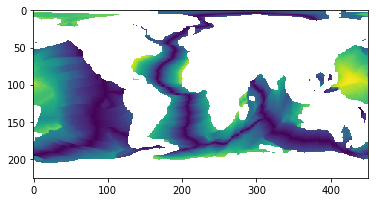

In [9]:
ages_reduced  = ages[::8,::8] # This is arbitrary, you should try some different ones
plt.imshow(ages_reduced)
plt.show()

ages_reduced2 = imresize(ages, (226,451), interp='bicubic', mode="F")
plt.imshow(ages_reduced2)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """Entry point for launching an IPython kernel.


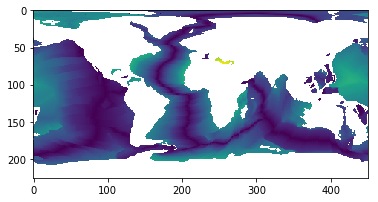

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """


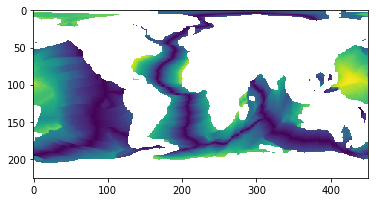

In [10]:
ages_reduced3 = imresize(ages, (226,451), interp='bilinear', mode="F")
plt.imshow(ages_reduced)
plt.show()

ages_reduced4 = imresize(ages, (226,451), interp='lanczos', mode="F")
plt.imshow(ages_reduced2)
plt.show()

### Task

Plot the age/depth data and see if it looks smoother.

Make a scatterplot with this data too (note: you will have to downsample the bathymetry too)

Does smoothing help bring out a trend ?


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


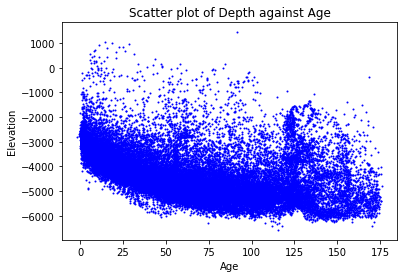

In [11]:
ages_reduced4 = imresize(ages, (226,451), interp='lanczos', mode="F")
etopoH_1_reduced4 = imresize(etopoH_1, (226,451), interp='lanczos', mode="F")

plt.scatter(ages_reduced4, etopoH_1_reduced4, c='blue', s=1, alpha=1)
plt.title('Scatter plot of Depth against Age')
plt.xlabel('Age')
plt.ylabel('Elevation')
plt.show()

### Task

Fit $ \textrm{depth} = A + B\sqrt{\textrm{age}} $ to this data and create a plot

You should be able to use 

```python
from scipy.optimize import curve_fit
help(curve_fit)
```



In [12]:
ages_reduced4

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [13]:
age_mask = np.isfinite(ages_reduced4)
ages_reduced5 = ages_reduced4[age_mask]

In [14]:
etopo_mask = np.isfinite(etopoH_1_reduced4)
etopoH_1_reduced5 = etopoH_1_reduced4[etopo_mask]

In [15]:
age_mask2 = ages_reduced5 > 0

ages_reduced6 = ages_reduced5[age_mask2]
etopoH_1_reduced6 = etopoH_1_reduced5[age_mask2]

In [16]:
len(etopoH_1_reduced6), len(ages_reduced6)

(40410, 40410)

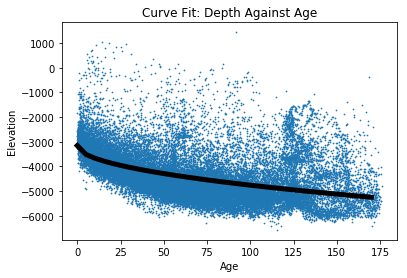

In [17]:
from scipy.optimize import curve_fit
#help(curve_fit)
x=np.arange(0,175,5)
y=etopoH_1_reduced6 

def function(x,A,B):
    return A + B*sqrt(x)

curve_fit(function, ages_reduced6, etopoH_1_reduced6)

plt.scatter(ages_reduced6, etopoH_1_reduced6, s=0.5)
plt.plot(x, function(x,-3154.59045955,-160.60203339), linewidth=5, color='black')
plt.title('Curve Fit: Depth Against Age')
plt.xlabel('Age')
plt.ylabel('Elevation')
plt.show()

In [18]:
#The curve seems to fit well with the data. 

### Discussion

Obviously there are problems with the data - looking at every pixel in the image does not account for regions where there are sea mounts or other features on the ocean floor that we might consider anomalous. Actually, the other reason this doesn't work very well is that it fails to account for sediment accumulation and loading.